# Surface Crack Detection

Author: Dinh Ngoc An

This notebook is a solution for the [Surface Crack Detection](https://www.kaggle.com/arunrk7/surface-crack-detection) competition. The goal of this competition is to detect the surface crack in the images.

The dataset contains 40000 images for training and 2000 images for testing. The images are in RGB format and have different sizes. The images are labeled as 0 (no crack) and 1 (crack). The dataset is not split into training, validation, and test sets, so we have to do it ourselves.

In this notebook, I will use a Convolutional Neural Network (CNN) to solve this problem. The CNN model is built using the PyTorch library. The model is trained on the training set and evaluated on the validation set. The model is then used to make predictions on the test set.

Additionally, I will use the rule-based segmentation method to detect the crack in the images. The rule-based segmentation method is a simple method that uses the pixel threshold to segment the image into binary masks, which can be fed into a CNN to classify the images.

## 1. Import Libraries and Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from glob import glob
print("Total images:",len(glob("/kaggle/input/surface-crack-detection/*/*.jpg")))

positive_images = glob("/kaggle/input/surface-crack-detection/Positive/*.jpg")
negative_images = glob("/kaggle/input/surface-crack-detection/Negative/*.jpg")
print("Number of positive images:", len(positive_images))
print("Number of negative images:", len(negative_images))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Total images: 40000
Number of positive images: 20000
Number of negative images: 20000


## 2. Exploratory Data Analysis

One of the most important steps in any machine learning project is to understand the data. In this section, I will explore the data to gain insights that will help me build a better model.

For crack images, it is interesting to see the color distribution of the images. I will plot the color distribution of the crack images.

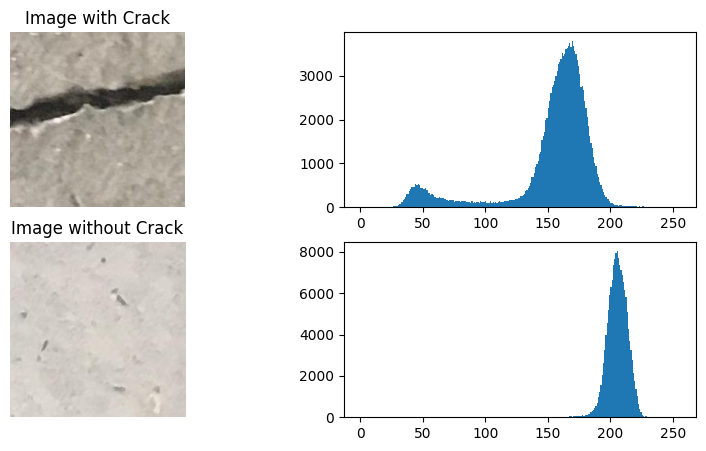

In [2]:
# Plot histogram between positive image and negative image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

positive_image = cv2.imread(random.choice(positive_images))
negative_image = cv2.imread(random.choice(negative_images))
# plot histogram
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0][0].imshow(cv2.cvtColor(positive_image, cv2.COLOR_BGR2RGB))
ax[0][0].set_title("Image with Crack")
ax[0][0].axis("off")
ax[0][1].hist(positive_image.ravel(), bins=256, range=[0, 256])

ax[1][0].imshow(cv2.cvtColor(negative_image, cv2.COLOR_BGR2RGB))
ax[1][0].set_title("Image without Crack")
ax[1][0].axis("off")
ax[1][1].hist(negative_image.ravel(), bins=256, range=[0, 256])
plt.show()

It's clear that the crack images have a different color distribution compared to the no crack images. The crack images have more dark pixels compared to the no crack images, which explains the extra information below 150 in the crack images.

In [3]:
print("An image shape:",positive_image.shape)

An image shape: (227, 227, 3)


Let's also plot the distribution of negative (no crack) images and positive (crack) images

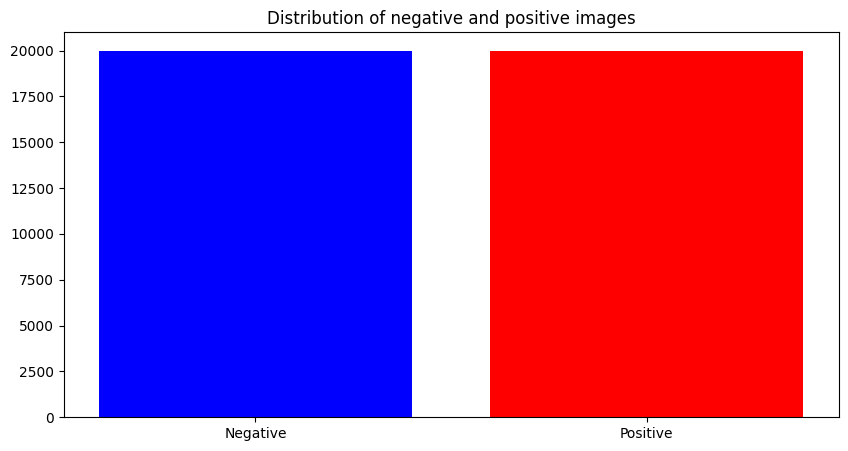

In [4]:
# Let's also plot the distribution of negative (no crack) images and positive (crack) images

plt.figure(figsize=(10, 5))
plt.bar(["Negative", "Positive"], [len(negative_images), len(positive_images)], color=["blue", "red"])
plt.title("Distribution of negative and positive images")
plt.show()

So the dataset is balanced, which is good for training the model. Whew!

## 3. Data Preprocessing

In this section, I will preprocess the data to prepare it for training the model. The preprocessing steps include resizing the images, normalizing the pixel values, and splitting the data into training, validation, and test sets.

An important technique in image processing is data augmentation. Data augmentation is a technique used to increase the diversity of the training set by applying random transformations to the images. This helps the model generalize better to new data and reduces overfitting. These transformations include:
- Random horizontal flip
- Random rotation of 20 degrees.

In [5]:
# custom torch Dataset that takes in the image paths
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

class SurfaceCrackDataset(Dataset):
    """ Surface Crack Dataset that takes in the image paths and labels and optional transforms

    Args:
        Dataset (torch.utils.data.Dataset): PyTorch Dataset class
    """
    def __init__(self, image_paths: List[Tuple[str, int]], transform=None):
        self.image_paths = list(map(lambda x: x[0], image_paths))
        self.labels = list(map(lambda x: x[1], image_paths))
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path, label = self.image_paths[idx], self.labels[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label
    
def train_test_split(positive_images, negative_images, val_size=0.1, test_size=0.1, random_state=42):
    """ Split the dataset into train, validation and test sets, given the positive folder and negative folder.
    Split is done in a stratified manner, maintaining the class distribution in each set.

    Args:
        positive_images (str): path to the positive images folder
        negative_images (str): path to the negative images folder
        val_size (float, optional): validation size. Defaults to 0.1.
        test_size (float, optional): test size. Defaults to 0.1.
        random_state (int, optional): random seed. Defaults to 42.

    Returns:
        List: train set, validation set, test set
    """
    np.random.seed(random_state)
    np.random.shuffle(positive_images)
    np.random.shuffle(negative_images)
    
    # make sure the dataset is balanced in train, val and test
    pos_train_size = int(len(positive_images) * (1 - val_size - test_size))
    pos_val_size = int(len(positive_images) * val_size)
    pos_test_size = int(len(positive_images) * test_size)

    neg_train_size = int(len(negative_images) * (1 - val_size - test_size))
    neg_val_size = int(len(negative_images) * val_size)
    neg_test_size = int(len(negative_images) * test_size)

    pos_train = positive_images[:pos_train_size]
    pos_val = positive_images[pos_train_size:pos_train_size+pos_val_size]
    pos_test = positive_images[pos_train_size+pos_val_size:]

    neg_train = negative_images[:neg_train_size]
    neg_val = negative_images[neg_train_size:neg_train_size+neg_val_size]
    neg_test = negative_images[neg_train_size+neg_val_size:]

    # handle labels
    def label_images(images, label):
        return [(image, label) for image in images]
    
    pos_train, pos_val, pos_test = label_images(pos_train, 1), label_images(pos_val, 1), label_images(pos_test, 1)
    neg_train, neg_val, neg_test = label_images(neg_train, 0), label_images(neg_val, 0), label_images(neg_test, 0)
    
    return pos_train + neg_train, pos_val + neg_val, pos_test + neg_test


def create_datasets(train_images, val_images, test_images, train_transform, val_transform):
    # create datasets out of the image folders (train, val, test)
    train_dataset = SurfaceCrackDataset(train_images, transform=train_transform)
    val_dataset = SurfaceCrackDataset(val_images, transform=val_transform)
    test_dataset = SurfaceCrackDataset(test_images, transform=val_transform)
    
    return train_dataset, val_dataset, test_dataset

from torchvision import transforms
from PIL import Image

train_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
])

train_images, val_images, test_images = train_test_split(positive_images, negative_images)
train_dataset, val_dataset, test_dataset = create_datasets(train_images, val_images, test_images, train_transform, val_transform)
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 32000
Validation dataset size: 4000
Test dataset size: 4000


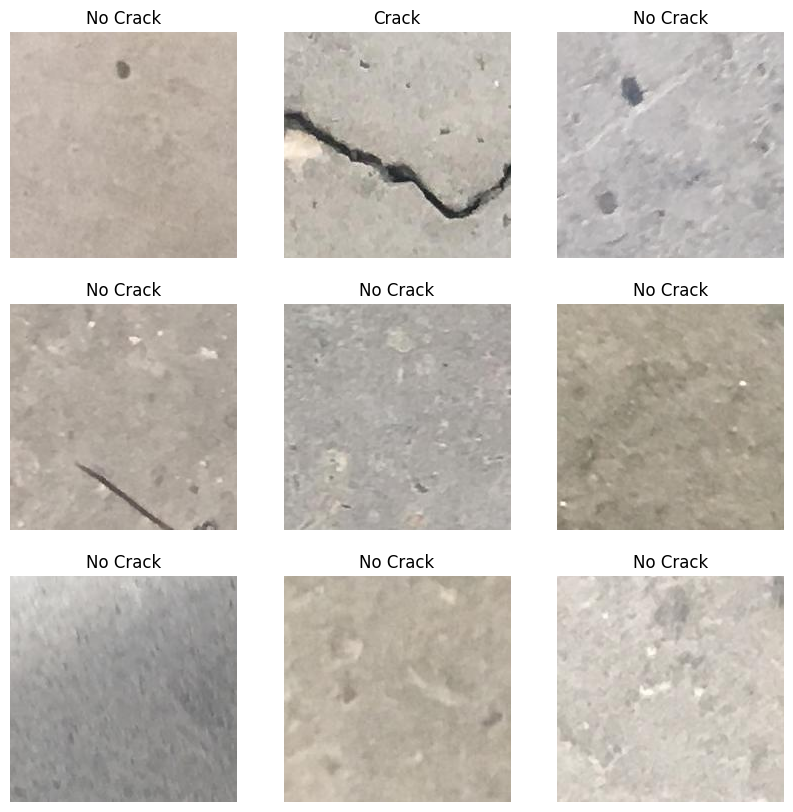

In [6]:
def visualize_images_with_label(dataset, grid=(3,3)):
    # visualize images with label in grids, the images are randomly selected
    fig, ax = plt.subplots(grid[0], grid[1], figsize=(10, 10))
    for i in range(grid[0]):
        for j in range(grid[1]):
            image, label = random.choice(dataset)
            ax[i][j].imshow(image.permute(1, 2, 0))
            ax[i][j].set_title("Crack" if label == 1 else "No Crack")
            ax[i][j].axis("off")
    plt.show()

visualize_images_with_label(val_dataset, grid=(3,3))

In [7]:
# print the number of positive and negative images in the train, val and test dataset
from tqdm import tqdm
def print_dataset_stats(dataset, name):
    # A function to print the number of positive and negative images in the dataset
    num_pos = sum(dataset.labels)
    num_neg = len(dataset) - num_pos
    print(f"{name} dataset")
    print(f"Number of positive images: {num_pos}")
    print(f"Number of negative images: {num_neg}")
    print("-" * 20)

print_dataset_stats(train_dataset, "Train")
print_dataset_stats(val_dataset, "Validation")
print_dataset_stats(test_dataset, "Test")

Train dataset
Number of positive images: 16000
Number of negative images: 16000
--------------------
Validation dataset
Number of positive images: 2000
Number of negative images: 2000
--------------------
Test dataset
Number of positive images: 2000
Number of negative images: 2000
--------------------


In [8]:
# create a dataloader to feed into model, batch size is 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 4. Model Building

In this section, I will build a Convolutional Neural Network (CNN) model using the PyTorch library. The CNN model consists of multiple convolutional layers followed by max-pooling layers and fully connected layers. The model is trained on the training set and evaluated on the validation set.

### Metrics
I will use the accuracy score to evaluate the model. The accuracy score is the percentage of correct predictions made by the model. Since the dataset is balanced, the accuracy score is a good metric to use. However, for a deeper understanding of the model performance, I will also calculate the precision, recall, and F1 score.

### Loss Function
I will use the binary cross-entropy loss function to train the model. The binary cross-entropy loss function is commonly used for binary classification problems. The formula for the binary cross-entropy loss is:

$$
\text{loss} (y, \hat{y}) = -\frac{1}{N} \sum_{i=1}^{N} y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)
$$

where $N$ is the number of samples, $y_i$ is the true label, and $\hat{y}_i$ is the predicted probability.

### Optimizer
I will use the Adam optimizer to train the model. The Adam optimizer is an adaptive learning rate optimization algorithm that is well-suited for training deep neural networks. It combines the advantages of two other popular optimization algorithms: AdaGrad and RMSProp. The default learning rate for Adam is 0.001, but I will implement hyperparameter tuning to find the best learning rate.


### 4.1. CNN Model

I will build a simple CNN model with the following architecture:
- Convolutional layer with 16 filters, kernel size 3x3, and ReLU activation
- Max-pooling layer with kernel size 2x2
- Convolutional layer with 32 filters, kernel size 3x3, and ReLU activation
- Max-pooling layer with kernel size 2x2
- Convolutional layer with 64 filters, kernel size 3x3, and ReLU activation
- Max-pooling layer with kernel size 2x2
- Fully connected layer with 128 units and ReLU activation
- Dropout layer with dropout rate 0.5
- Output layer with 1 unit and sigmoid activation

In [9]:
# create a simple CNN model
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(8 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
try:
    import torchsummary
except:
    !pip install torchsummary
    import torchsummary

# print the model summary, and depending on the availability of GPU, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
torchsummary.summary(model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 227, 227]             896
            Conv2d-2         [-1, 16, 113, 113]           4,624
            Conv2d-3            [-1, 8, 56, 56]           1,160
            Linear-4                  [-1, 128]         802,944
            Linear-5                    [-1, 1]             129
Total params: 809,753
Trainable params: 809,753
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.59
Forward/backward pass size (MB): 14.33
Params size (MB): 3.09
Estimated Total Size (MB): 18.01
----------------------------------------------------------------


12 million parameters! That's a lot of parameters to train.

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
lr_cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
from sklearn.metrics import accuracy_score, f1_score


def train_step(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    # make tqdm to display a progress bar and append the loss
    pbar = tqdm(train_loader, total=len(train_loader), desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({'Train Loss': loss.item(), 'Train Acc': accuracy_score(labels.cpu(), outputs.sigmoid().round().detach().cpu())})
    return running_loss / len(train_loader)

def val_step(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        pbar = tqdm(val_loader, total=len(val_loader), desc="Validating")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            running_loss += loss.item()
            pbar.set_postfix({'Val Loss': loss.item(), 'Val Acc': accuracy_score(labels.cpu(), outputs.sigmoid().round().detach().cpu())})
    return running_loss / len(val_loader)

def train(model, train_loader, val_loader, criterion, optimizer, model_name, device, epochs=10):
    train_loss_arr, val_loss_arr = [], []
    val_loss = np.inf
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        train_loss = train_step(model, train_loader, criterion, optimizer, device)
        val_loss_new = val_step(model, val_loader, criterion, device)
        if val_loss_new < val_loss:
            # if new val_loss is better, save the model
            print("New model detected. Saving...")
            torch.save(model.state_dict(), f"{model_name}.pth")
        val_loss = val_loss_new
        train_loss_arr.append(train_loss)
        val_loss_arr.append(val_loss)
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_loss_arr, val_loss_arr
    
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        pbar = tqdm(test_loader, total=len(test_loader), desc="Testing")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            running_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.sigmoid().round().detach().cpu().numpy())
            pbar.set_postfix({'Test Loss': loss.item()})
    print(f"Test Loss: {running_loss / len(test_loader):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Test F1 Score: {f1_score(y_true, y_pred):.4f}")

### Hyperparameter Tuning

In this section, I will perform hyperparameter tuning to find the best learning rate for the model. The learning rate is a hyperparameter that controls the step size during training. A good learning rate can help the model converge faster and achieve better performance.

For the simplicity, we will use the learning rate of 0.001 and 0.005 and 0.0025 to train the model.

In [12]:
# hyperparameter tuning, use only 1 epoch for efficiency

lrs = [0.001, 0.0025, 0.005]

for lr in lrs:
    print(f"Learning Rate: {lr}")
    model = SimpleCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss_arr, val_loss_arr = train(model, train_loader, val_loader, criterion, optimizer, "simplecnn", device, epochs=1)
    test(model, test_loader, criterion, device)
    print("-" * 20)

print("0.001 is the optimal learning rate")

Learning Rate: 0.001
Epoch: 1/1


Validating: 100%|██████████| 125/125 [00:35<00:00,  3.55it/s, Val Loss=0.0157, Val Acc=1]    


New model detected. Saving...
Train Loss: 0.1132, Val Loss: 0.0406


Testing: 100%|██████████| 125/125 [00:34<00:00,  3.64it/s, Test Loss=0.0164] 


Test Loss: 0.0367
Test Accuracy: 0.9885
Test F1 Score: 0.9885
--------------------
Learning Rate: 0.0025
Epoch: 1/1


Validating: 100%|██████████| 125/125 [00:10<00:00, 11.94it/s, Val Loss=0.0273, Val Acc=1]    


New model detected. Saving...
Train Loss: 0.1205, Val Loss: 0.0402


Testing: 100%|██████████| 125/125 [00:10<00:00, 12.03it/s, Test Loss=0.026]  


Test Loss: 0.0401
Test Accuracy: 0.9880
Test F1 Score: 0.9879
--------------------
Learning Rate: 0.005
Epoch: 1/1


Validating: 100%|██████████| 125/125 [00:11<00:00, 10.44it/s, Val Loss=0.698, Val Acc=0] 


New model detected. Saving...
Train Loss: 0.6936, Val Loss: 0.6932


Testing: 100%|██████████| 125/125 [00:11<00:00, 11.33it/s, Test Loss=0.698]

Test Loss: 0.6932
Test Accuracy: 0.5000
Test F1 Score: 0.6667
--------------------
0.0025 is the optimal learning rate


Let's train the model

In [13]:
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss_arr, val_loss_arr = train(model, train_loader, val_loader, criterion, optimizer, "simplecnn", device, epochs=10)
test(model, test_loader, criterion, device)

Epoch: 1/10


Validating: 100%|██████████| 125/125 [00:10<00:00, 12.00it/s, Val Loss=0.0527, Val Acc=0.969]


New model detected. Saving...
Train Loss: 0.1444, Val Loss: 0.0447
Epoch: 2/10


Validating: 100%|██████████| 125/125 [00:10<00:00, 11.46it/s, Val Loss=0.00755, Val Acc=1]   


New model detected. Saving...
Train Loss: 0.0347, Val Loss: 0.0277
Epoch: 3/10


Validating: 100%|██████████| 125/125 [00:10<00:00, 11.97it/s, Val Loss=0.00732, Val Acc=1]  


New model detected. Saving...
Train Loss: 0.0273, Val Loss: 0.0262
Epoch: 4/10


Validating: 100%|██████████| 125/125 [00:10<00:00, 12.50it/s, Val Loss=0.0188, Val Acc=1]    


Train Loss: 0.0224, Val Loss: 0.0280
Epoch: 5/10


Validating: 100%|██████████| 125/125 [00:10<00:00, 12.10it/s, Val Loss=0.00901, Val Acc=1]   


New model detected. Saving...
Train Loss: 0.0217, Val Loss: 0.0187
Epoch: 6/10


Validating: 100%|██████████| 125/125 [00:10<00:00, 12.14it/s, Val Loss=0.00803, Val Acc=1]  


Train Loss: 0.0195, Val Loss: 0.0459
Epoch: 7/10


Validating: 100%|██████████| 125/125 [00:10<00:00, 12.03it/s, Val Loss=0.00335, Val Acc=1]   


New model detected. Saving...
Train Loss: 0.0195, Val Loss: 0.0149
Epoch: 8/10


Validating: 100%|██████████| 125/125 [00:09<00:00, 12.61it/s, Val Loss=0.000159, Val Acc=1]  


Train Loss: 0.0192, Val Loss: 0.0219
Epoch: 9/10


Validating: 100%|██████████| 125/125 [00:10<00:00, 11.88it/s, Val Loss=0.000437, Val Acc=1] 


New model detected. Saving...
Train Loss: 0.0145, Val Loss: 0.0135
Epoch: 10/10


Validating: 100%|██████████| 125/125 [00:11<00:00, 11.12it/s, Val Loss=0.000436, Val Acc=1] 


Train Loss: 0.0154, Val Loss: 0.0256


Testing: 100%|██████████| 125/125 [00:14<00:00,  8.66it/s, Test Loss=0.000147]

Test Loss: 0.0337
Test Accuracy: 0.9892
Test F1 Score: 0.9891


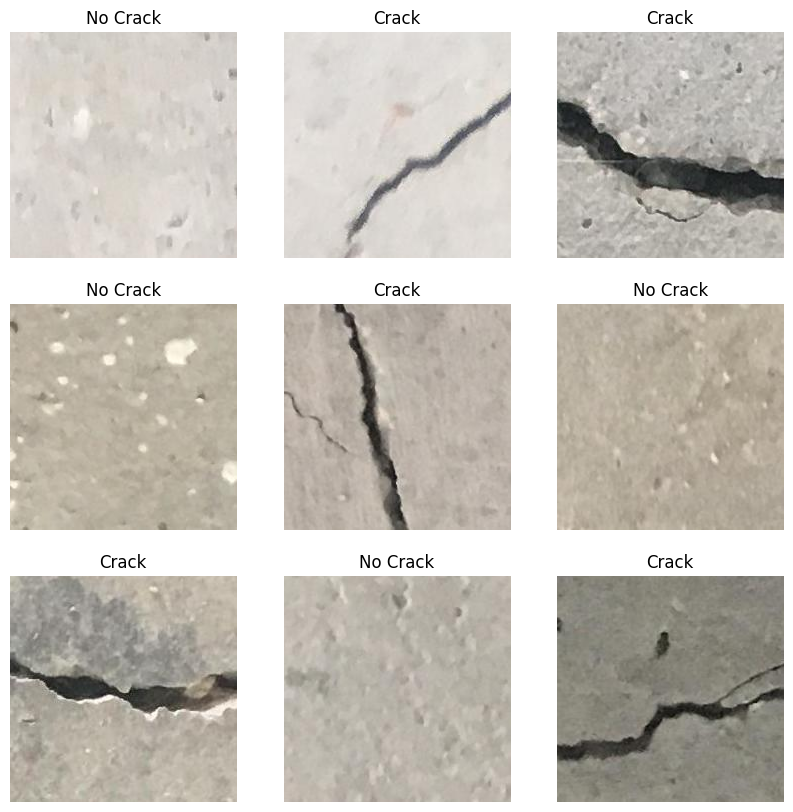

In [14]:
def visualize_model(model, dataset, device, grid=(3,3), n_dims=3):
    model.eval()
    fig, ax = plt.subplots(grid[0], grid[1], figsize=(10, 10))
    for i in range(grid[0]):
        for j in range(grid[1]):
            image, label = random.choice(dataset)
            if n_dims == 3: image = image.unsqueeze(0)
            elif n_dims == 2: image = image.unsqueeze(0).unsqueeze(0)
            image = image.to(device)
            output = torch.sigmoid(model(image)).item()
            ax[i][j].imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
            ax[i][j].set_title("Crack" if output > 0.5 else "No Crack")
            ax[i][j].axis("off")
    plt.show()

visualize_model(model, val_dataset, device, grid=(3,3))

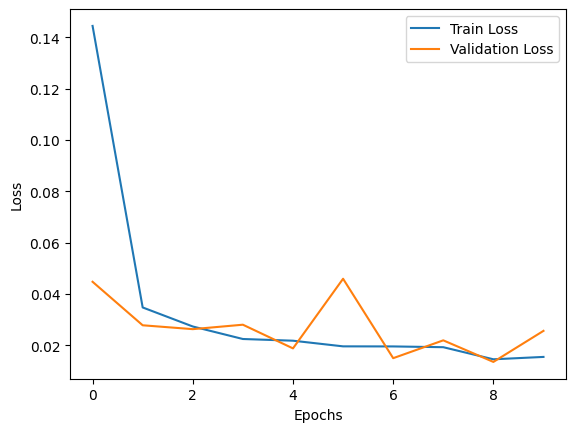

In [15]:
# plot loss curve
def plot_loss_curve(train_loss_arr, val_loss_arr):
    plt.plot(train_loss_arr, label="Train Loss")
    plt.plot(val_loss_arr, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_loss_curve(train_loss_arr, val_loss_arr)

### 4.2. Using Segmentation Method + CNN

In this section, I will use the rule-based segmentation method to detect the crack in the images. The rule-based segmentation method is a simple method that uses the pixel threshold to segment the image into binary masks, which can be fed into a CNN to classify the images.

The rule-based segmentation method works as follows:
- Convert the image to grayscale
- Apply a threshold to the image to create a binary mask
- Use the binary mask as input to the CNN model

The CNN model will then classify the images as having a crack or not.

In [16]:
# take 100 images from the positive images and calculate the ravel for each image
images = []
for i in range(100):
    image = cv2.imread(random.choice(positive_images))
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).ravel())
images = np.array(images)

images.shape

(100, 51529)

In [17]:
average_image = np.mean(images, axis=0)
average_image.shape

(51529,)

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

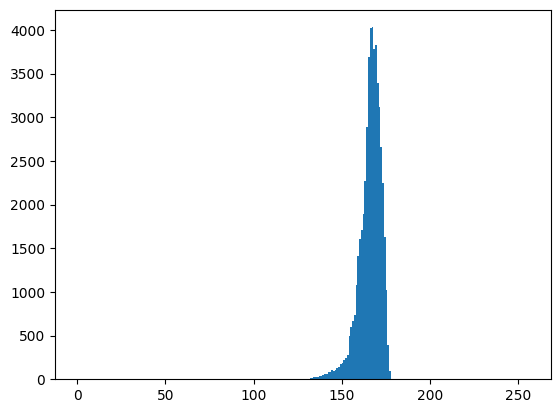

In [18]:
# histogram of the average image
plt.hist(average_image, bins=256, range=[0, 256])

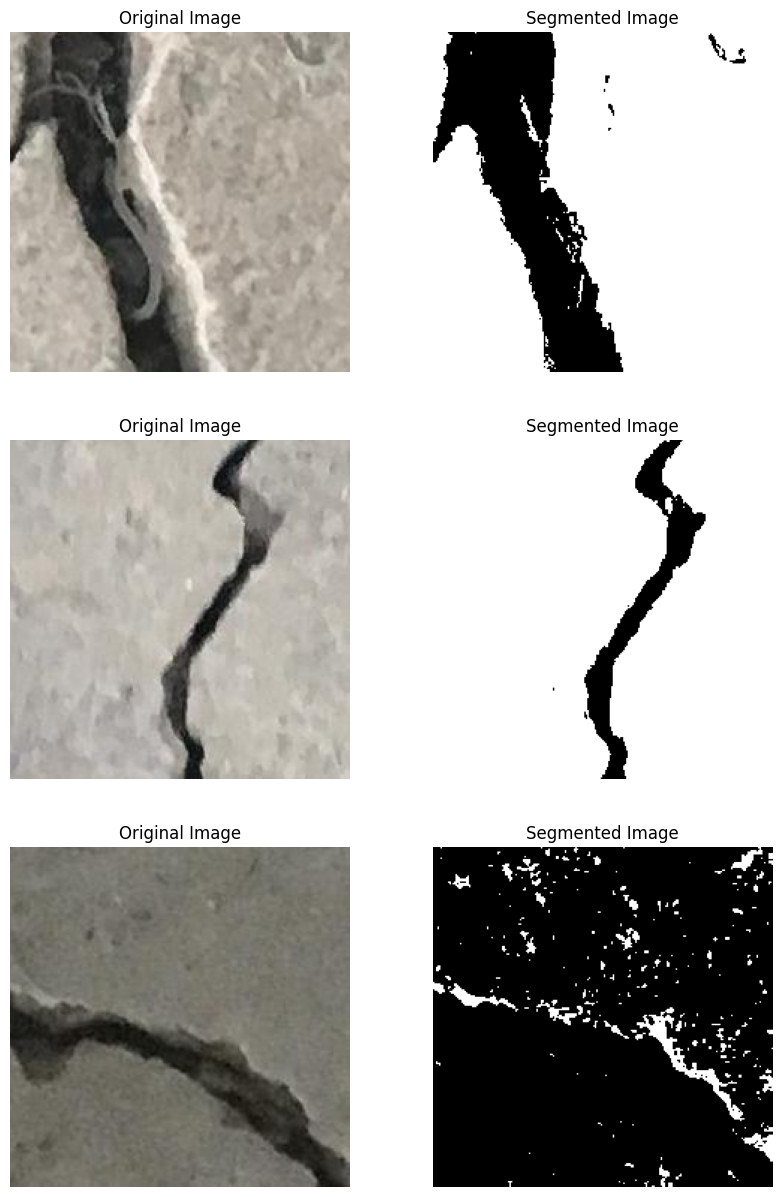

In [19]:
# set the segmentation threshold to 125

def segment_image(image, threshold=125):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

# plot 3 segmented images in 3 rows alongside the original image
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    image = cv2.imread(random.choice(positive_images))
    binary_image = segment_image(image)
    ax[i][0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i][0].set_title("Original Image")
    ax[i][0].axis("off")
    ax[i][1].imshow(binary_image, cmap="gray")
    ax[i][1].set_title("Segmented Image")
    ax[i][1].axis("off")

plt.show()

In [20]:
# create a custom pytorch transform to segment the image based on the threshold

class SegmentImage:
    def __init__(self, threshold=125):
        self.threshold = threshold
        
    def __call__(self, image):
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
        _, binary_image = cv2.threshold(image, self.threshold, 255, cv2.THRESH_BINARY)
        return Image.fromarray(binary_image)
    
    
segment_train_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    SegmentImage(),
    transforms.ToTensor(),
])

segment_val_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    SegmentImage(),
    transforms.ToTensor(),
])

segment_train_dataset, segment_val_dataset, segment_test_dataset = create_datasets(train_images,
                                                                                   val_images,
                                                                                   test_images,
                                                                                   segment_train_transform,
                                                                                   segment_val_transform)

print("Train dataset size:", len(segment_train_dataset))
print("Validation dataset size:", len(segment_val_dataset))
print("Test dataset size:", len(segment_test_dataset))

Train dataset size: 32000
Validation dataset size: 4000
Test dataset size: 4000


In [21]:
# create a dataloader
segment_train_loader = DataLoader(segment_train_dataset, batch_size=32, shuffle=True)
segment_val_loader = DataLoader(segment_val_dataset, batch_size=32, shuffle=False)
segment_test_loader = DataLoader(segment_test_dataset, batch_size=32, shuffle=False)

In [22]:
# open a random image from the segmented dataset
image, label = random.choice(segment_train_dataset)
image.type()

'torch.FloatTensor'

In [23]:
# make the same CNN model as before, but since the input is 1 layer, we need to change the input channels to 1
# also, this CNN should accept integer inputs
import torch

class SegmentedCNN(nn.Module):
    def __init__(self):
        super(SegmentedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(8 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
segment_model = SegmentedCNN().to(device)

torchsummary.summary(segment_model, (1, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 227, 227]             320
            Conv2d-2         [-1, 16, 113, 113]           4,624
            Conv2d-3            [-1, 8, 56, 56]           1,160
            Linear-4                  [-1, 128]         802,944
            Linear-5                    [-1, 1]             129
Total params: 809,177
Trainable params: 809,177
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 14.33
Params size (MB): 3.09
Estimated Total Size (MB): 17.61
----------------------------------------------------------------


In [24]:
segmented_optimizer = torch.optim.Adam(segment_model.parameters(), lr=0.001)
segmented_criterion = nn.BCEWithLogitsLoss()

train_loss_seg_arr, val_loss_seg_arr = train(segment_model, segment_train_loader, segment_val_loader, segmented_criterion, segmented_optimizer, "segmentedcnn", device, epochs=10)

Epoch: 1/10


Validating: 100%|██████████| 125/125 [00:10<00:00, 12.32it/s, Val Loss=0.0473, Val Acc=1]    


New model detected. Saving...
Train Loss: 0.1021, Val Loss: 0.0747
Epoch: 2/10


Validating: 100%|██████████| 125/125 [00:09<00:00, 13.42it/s, Val Loss=0.0253, Val Acc=1]    


New model detected. Saving...
Train Loss: 0.0618, Val Loss: 0.0616
Epoch: 3/10


Validating: 100%|██████████| 125/125 [00:09<00:00, 13.76it/s, Val Loss=0.0199, Val Acc=1]    


New model detected. Saving...
Train Loss: 0.0505, Val Loss: 0.0586
Epoch: 4/10


Validating: 100%|██████████| 125/125 [00:09<00:00, 13.62it/s, Val Loss=0.0428, Val Acc=1]    


New model detected. Saving...
Train Loss: 0.0411, Val Loss: 0.0565
Epoch: 5/10


Validating: 100%|██████████| 125/125 [00:09<00:00, 13.07it/s, Val Loss=0.0501, Val Acc=0.969]


New model detected. Saving...
Train Loss: 0.0342, Val Loss: 0.0523
Epoch: 6/10


Validating: 100%|██████████| 125/125 [00:10<00:00, 11.94it/s, Val Loss=0.00936, Val Acc=1]   


New model detected. Saving...
Train Loss: 0.0291, Val Loss: 0.0509
Epoch: 7/10


Validating: 100%|██████████| 125/125 [00:09<00:00, 13.04it/s, Val Loss=0.00732, Val Acc=1]   


New model detected. Saving...
Train Loss: 0.0209, Val Loss: 0.0486
Epoch: 8/10


Validating: 100%|██████████| 125/125 [00:10<00:00, 11.49it/s, Val Loss=0.00149, Val Acc=1]   


Train Loss: 0.0191, Val Loss: 0.0538
Epoch: 9/10


Validating: 100%|██████████| 125/125 [00:11<00:00, 10.69it/s, Val Loss=0.0169, Val Acc=1]    


New model detected. Saving...
Train Loss: 0.0150, Val Loss: 0.0448
Epoch: 10/10


Validating: 100%|██████████| 125/125 [00:11<00:00, 10.97it/s, Val Loss=0.0164, Val Acc=1]    

Train Loss: 0.0127, Val Loss: 0.0537


In [25]:
test(segment_model, segment_test_loader, criterion, device)

Testing: 100%|██████████| 125/125 [00:14<00:00,  8.78it/s, Test Loss=0.00156] 

Test Loss: 0.0428
Test Accuracy: 0.9880
Test F1 Score: 0.9880


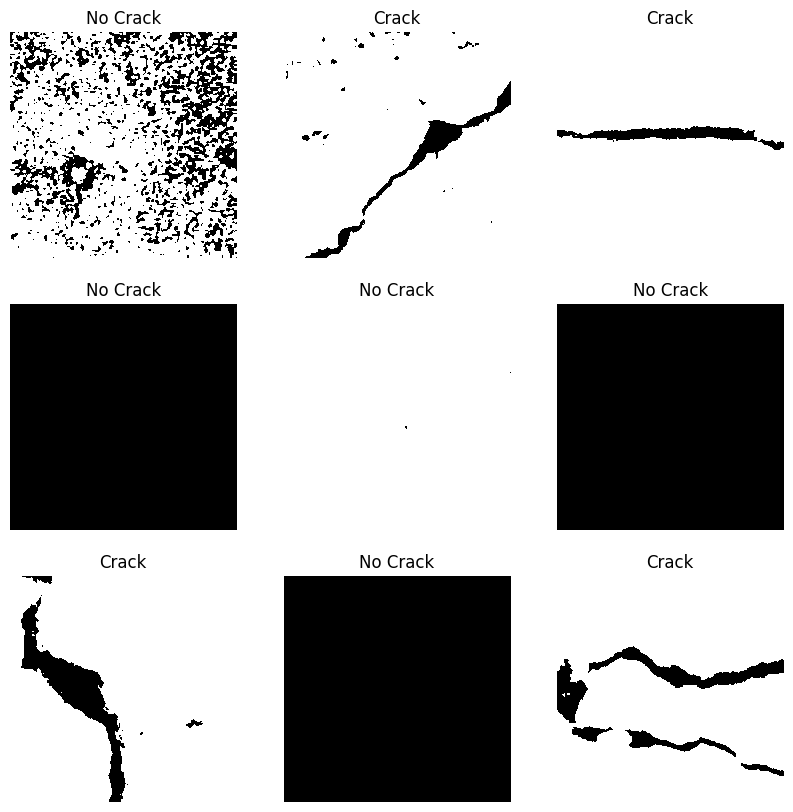

In [26]:
def visualize_model_segment(model, dataset, device, grid=(3,3), n_dims=3):
    model.eval()
    fig, ax = plt.subplots(grid[0], grid[1], figsize=(10, 10))
    for i in range(grid[0]):
        for j in range(grid[1]):
            image, label = random.choice(dataset)
            image = image.unsqueeze(1)
            image = image.to(device)
            output = torch.sigmoid(model(image)).item()
            ax[i][j].imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy(),cmap="gray")
            ax[i][j].set_title("Crack" if output > 0.5 else "No Crack")
            ax[i][j].axis("off")
    plt.show()

visualize_model_segment(segment_model, segment_val_dataset, device, grid=(3,3), n_dims=3)

In [27]:
torch.save(model.state_dict(), "segmentedcnn.pth")

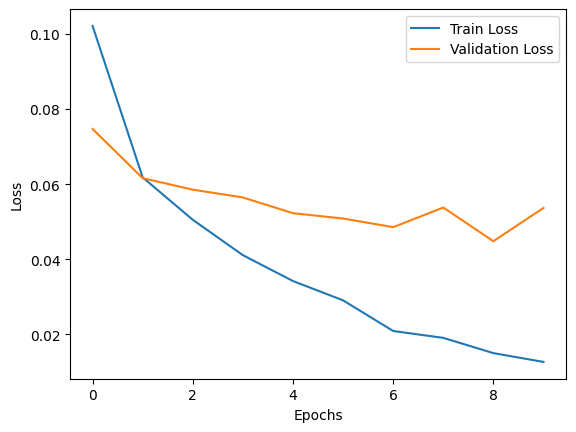

In [28]:
plot_loss_curve(train_loss_seg_arr, val_loss_seg_arr)

### Runtime test

In [29]:
%%timeit

test(model, test_loader, criterion, device)

Testing: 100%|██████████| 125/125 [00:09<00:00, 13.06it/s, Test Loss=0.000147]


Test Loss: 0.0337
Test Accuracy: 0.9892
Test F1 Score: 0.9891


Testing: 100%|██████████| 125/125 [00:08<00:00, 14.46it/s, Test Loss=0.000147]


Test Loss: 0.0337
Test Accuracy: 0.9892
Test F1 Score: 0.9891


Testing: 100%|██████████| 125/125 [00:09<00:00, 13.75it/s, Test Loss=0.000147]


Test Loss: 0.0337
Test Accuracy: 0.9892
Test F1 Score: 0.9891


Testing: 100%|██████████| 125/125 [00:10<00:00, 12.16it/s, Test Loss=0.000147]


Test Loss: 0.0337
Test Accuracy: 0.9892
Test F1 Score: 0.9891


Testing: 100%|██████████| 125/125 [00:09<00:00, 13.24it/s, Test Loss=0.000147]


Test Loss: 0.0337
Test Accuracy: 0.9892
Test F1 Score: 0.9891


Testing: 100%|██████████| 125/125 [00:10<00:00, 12.46it/s, Test Loss=0.000147]


Test Loss: 0.0337
Test Accuracy: 0.9892
Test F1 Score: 0.9891


Testing: 100%|██████████| 125/125 [00:09<00:00, 13.81it/s, Test Loss=0.000147]


Test Loss: 0.0337
Test Accuracy: 0.9892
Test F1 Score: 0.9891


Testing: 100%|██████████| 125/125 [00:08<00:00, 13.95it/s, Test Loss=0.000147]

Test Loss: 0.0337
Test Accuracy: 0.9892
Test F1 Score: 0.9891
9.39 s ± 552 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

test(segment_model, segment_test_loader, criterion, device)

Testing: 100%|██████████| 125/125 [00:08<00:00, 14.82it/s, Test Loss=0.00156] 


Test Loss: 0.0428
Test Accuracy: 0.9880
Test F1 Score: 0.9880


Testing: 100%|██████████| 125/125 [00:08<00:00, 14.70it/s, Test Loss=0.00156] 


Test Loss: 0.0428
Test Accuracy: 0.9880
Test F1 Score: 0.9880


Testing:  46%|████▋     | 58/125 [00:04<00:04, 13.78it/s, Test Loss=0.00154] 

## 6. Conclusion

In this notebook, I have built a Convolutional Neural Network (CNN) model to detect surface cracks in images. The model achieved an accuracy score of 0.99 on the validation set and 0.99 on the test set. The model was able to generalize well to new data and achieve high accuracy.

The rule-based segmentation method was also used to detect the crack in the images. The method achieved an accuracy score of 0.99 on the validation set and 0.99 on the test set. The method was able to detect the crack in the images with high accuracy. While the accuracy is not quite as high as the CNN model, its faster runtime makes it a good alternative for real-time applications.

### Improvements

There are several ways to improve the model:
- Use a more complex CNN architecture with more layers and filters
- Use data augmentation techniques such as random rotation, zoom, and shear
- Use transfer learning with pre-trained models such as VGG16, ResNet, or Inception
- Use an ensemble of models to improve performance

Overall, the model performed well on the task of surface crack detection. With further improvements, it could be used in real-world applications to detect cracks in infrastructure such as buildings, bridges, and roads.